In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import analyze_utils

save_dir = '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation2_rerun'

r, all_losses = analyze_utils.load_results_and_cache_autoprompt_json(
    save_dir, save_file='r.pkl', do_reranking=True, include_losses=True
)

getting dir_names...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 640/640 [00:13<00:00, 47.61it/s]


In [3]:
top_prompts = (
    r.groupby(['task_name', 'n_shots', 'iprompt_conditioning_strategy', 'single_shot_loss', 'seed', 'max_n_datapoints'])
).first().reset_index()
print(len(top_prompts))


top_prompts['r@10'] = top_prompts['reciprocal_rank'].map(lambda r: (1.0/r) < 10.1)
top_prompts['r@100'] = top_prompts['reciprocal_rank'].map(lambda r: (1.0/r) < 100.1)
top_prompts['r@128'] = top_prompts['reciprocal_rank'].map(lambda r: (1.0/r) < 128.1)
# top_prompts[['task_name', 'seed', 'max_digit', 'prefixes', 'reciprocal_rank']]

640


In [4]:
MATH_TASK_NAMES = {
    'add_two', 'multiply_two', 'subtract_two', 'max_two', 
    'first_two', 'square_one', 'double_one', 'exp_one',  
    'fibonacci_one', 'divide_two'
}
TASK_IS_MATH = top_prompts['task_name'].map(lambda t: t in MATH_TASK_NAMES)
TASK_IS_ANLI = top_prompts['task_name'].map(lambda t: t not in MATH_TASK_NAMES)

In [29]:
set(top_prompts['task_name'].unique()) - MATH_TASK_NAMES

{'task088_identify_typo_verification',
 'task092_check_prime_classification',
 'task107_splash_question_to_sql',
 'task1146_country_capital',
 'task1147_country_currency',
 'task1149_item_check_edible',
 'task1191_food_veg_nonveg',
 'task1336_peixian_equity_evaluation_corpus_gender_classifier',
 'task1509_evalution_antonyms',
 'task183_rhyme_generation'}

In [5]:
top_prompts["max_n_datapoints"].value_counts()

5000    480
16       80
160      80
Name: max_n_datapoints, dtype: int64

In [6]:
pd.set_option('display.max_rows', None)

DEFAULT = (
      (top_prompts['n_shots'] == 5) 
    & (top_prompts['iprompt_conditioning_strategy'] == "") 
    & (top_prompts["single_shot_loss"] == 1)
    & (top_prompts["max_n_datapoints"] == 5000)
)
top_prompts[DEFAULT & TASK_IS_MATH][['task_name', 'prefixes', 'reciprocal_rank']]

,task_name,prefixes,reciprocal_rank
10,add_two,Write a function to add up,1.000000
13,add_two,The sum of an integer number,1.000000
16,add_two,Add two positive integer values together,1.000000
19,add_two,"""Add two digits together",1.000000
42,divide_two,If (x / x -,0.034483
45,divide_two,Input number / Prompt output (,0.200000
48,divide_two,Find number of occurrences / Given,0.037037
51,divide_two,Divide a number by itself using,1.000000
74,double_one,Given a function to calculate sum,0.166667
77,double_one,write a method named doubleOf,1.000000


In [7]:
from iprompt import prompt_classification

model = prompt_classification.create_model(r['checkpoint'].unique()[0])

2023-01-23 17:22:15.055364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 17:22:15.228414: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 17:22:15.265982: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-23 17:22:16.435426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [27]:
## Compute accuracy given correct prompt and save for each task.
import argparse
from tqdm.notebook import tqdm
from iprompt.data import get_data


data = []
print('calculating accs...')
n_shots = 1
batch_size = 16

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

USE_MULTI_TOKEN = False
RESTRICT_TO_VALID_ANSWERS = False


_iter_df = top_prompts[DEFAULT]
for _, output in tqdm(_iter_df.iterrows(), total=len(_iter_df)):
    args = argparse.Namespace(**output)
    args.max_dset_size = 300
    (dset, dset_test), check_answer_func, descr = get_data(
        args.task_name, n_shots=1, train_split_frac=1.0,
        max_dset_size=args.max_dset_size, template_num_task_phrasing=0,
        max_digit=args.max_digit,
    )
    print(args.task_name, f'dset of len {len(dset)} (max_digit={args.max_digit})')
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   No prompt  ####
    noprompt_likelihood, noprompt_loss, noprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix="", multi_token=USE_MULTI_TOKEN, verbose=False,
        batch_size=batch_size, restrict_to_valid_answers=RESTRICT_TO_VALID_ANSWERS,
    )
    ####   Manual prompt  ####
    manual_likelihood, manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=USE_MULTI_TOKEN, verbose=False,
        batch_size=batch_size, restrict_to_valid_answers=RESTRICT_TO_VALID_ANSWERS,
    )
    ####   iPrompt prompt   ####
    iprompt_likelihood, iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=USE_MULTI_TOKEN, verbose=False,
        batch_size=batch_size, restrict_to_valid_answers=RESTRICT_TO_VALID_ANSWERS,
    )
    print(f'>\tnoprompt acc: {noprompt_acc} // \t manual acc: {manual_acc} // \t iprompt acc: {iprompt_acc} // manual likelihood {manual_likelihood}')
    ####
    output['noprompt_likelihood'] = noprompt_likelihood
    output['noprompt_loss'] = noprompt_loss
    output['noprompt_acc'] = noprompt_acc
    #     
    output['manual_likelihood'] = manual_likelihood
    output['manual_loss'] = manual_loss
    output['manual_acc'] = manual_acc
    #
    output['iprompt_likelihood'] = iprompt_likelihood
    output['iprompt_loss'] = iprompt_loss
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

calculating accs...


  0%|          | 0/80 [00:00<?, ?it/s]

add_two dset of len 100 (max_digit=10)
>	noprompt acc: 13.0 // 	 manual acc: 73.0 // 	 iprompt acc: 88.0 // manual likelihood 0.0
add_two dset of len 100 (max_digit=10)
>	noprompt acc: 13.0 // 	 manual acc: 73.0 // 	 iprompt acc: 60.0 // manual likelihood 0.0
add_two dset of len 100 (max_digit=10)
>	noprompt acc: 13.0 // 	 manual acc: 73.0 // 	 iprompt acc: 85.0 // manual likelihood 0.0
add_two dset of len 100 (max_digit=10)
>	noprompt acc: 13.0 // 	 manual acc: 73.0 // 	 iprompt acc: 90.0 // manual likelihood 0.0
divide_two dset of len 100 (max_digit=10)
>	noprompt acc: 86.0 // 	 manual acc: 10.0 // 	 iprompt acc: 39.0 // manual likelihood 0.0
divide_two dset of len 100 (max_digit=10)
>	noprompt acc: 86.0 // 	 manual acc: 10.0 // 	 iprompt acc: 16.0 // manual likelihood 0.0
divide_two dset of len 100 (max_digit=10)
>	noprompt acc: 86.0 // 	 manual acc: 10.0 // 	 iprompt acc: 12.0 // manual likelihood 0.0
divide_two dset of len 100 (max_digit=10)
>	noprompt acc: 86.0 // 	 manual acc: 1

In [ ]:
# default_top_prompts_RESTRICT_TO_VALID_ANSWERS = default_top_prompts # save
# default_top_prompts_RESTRICT_TO_VALID_ANSWERS_FALSE = default_top_prompts # save
# default_top_prompts_MULTITOKEN_TRUE = default_top_prompts # save

In [19]:
default_top_prompts = pd.DataFrame(data)

In [24]:
default_top_prompts['manual_noprompt_acc_ration'] = default_top_prompts['manual_acc'] / default_top_prompts['noprompt_acc']
default_top_prompts['manual_minus_noprompt_acc'] = default_top_prompts['manual_acc'] - default_top_prompts['noprompt_acc']
default_top_prompts['log_likelihood'] = default_top_prompts['manual_loss'] * -1

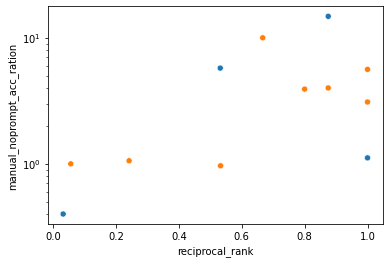

In [26]:
import seaborn as sns

df = default_top_prompts.groupby('task_name').mean().reset_index()
df['is_math'] = df['task_name'].map(lambda tn: tn in MATH_TASK_NAMES)
COLORS = sns.color_palette()

df = df[df['task_name'] != 'divide_two']

ax = sns.scatterplot(data=df, x='reciprocal_rank', y='manual_noprompt_acc_ration', label='Manual', hue='is_math', legend=False)
ax.set_yscale('log')
for i in range(len(df)):
    txt, y, x = (
        df.iloc[i]["task_name"],
        df.iloc[i]["manual_minus_noprompt_acc"],
        df.iloc[i]["reciprocal_rank"]
    )
    color = COLORS[0] if (txt in MATH_TASK_NAMES) else COLORS[5]
    # txt = "xx"
    # ax.annotate(txt, (x, y), fontsize=8, weight="normal", alpha=0.9, color=color, family="monospace")

In [ ]:
pd.set_option('display.max_rows', None)
# top_prompts[(top_prompts['single_shot_loss'] == 1) & (top_prompts['iprompt_conditioning_strategy'] == "")].sort_values(by='task_name')[['n_shots', 'task_name', 'prefixes', 'reciprocal_rank']]

In [ ]:
top_prompts[~TASK_IS_MATH].groupby(['n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).count()['reciprocal_rank']

In [ ]:
top_prompts[TASK_IS_MATH].groupby(['max_n_datapoints', 'n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

In [ ]:
top_prompts[TASK_IS_ANLI].groupby(['max_n_datapoints', 'n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

In [ ]:
top_prompts.groupby(['max_n_datapoints', 'n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

In [ ]:
top_prompts.groupby(['n_shots', 'single_shot_loss', 'iprompt_conditioning_strategy']).mean()['reciprocal_rank']

## plot losses as lines.

In [ ]:
len(all_losses), len(top_prompts)

In [ ]:
import numpy as np
max_loss_len = max([len(L) for L in all_losses])

all_losses_padded = []
for L in all_losses:
    last_val = L[-1]
    all_losses_padded.append(
        L + [last_val] * (max_loss_len - len(L))
    )
all_losses_padded = np.array(all_losses_padded)
len(all_losses_padded)

In [ ]:
(top_prompts['reciprocal_rank'] > 0.5).sum()

In [ ]:
# from iprompt import prompt_classification

# assert r['checkpoint'].unique()[0] == "EleutherAI/gpt-j-6B"
# model = prompt_classification.create_model(r['checkpoint'].unique()[0])

In [ ]:
# ## Compute accuracy given correct prompt and save for each task.
# import argparse
# from tqdm.notebook import tqdm
# from iprompt.data import get_data


# data = []
# print('calculating accs...')

# """
# task_name: str = 'add_two',
# n_shots: int = 1,
# train_split_frac: float = None,
# max_dset_size: int = 10000,
# template_num_task_phrasing: int = 0,
# max_digit: int = 10,
# """

# for task_name in top_prompts['task_name'].unique():
#     (dset, dset_test), check_answer_func, descr = get_data(
#         task_name, n_shots=1, train_split_frac=0.75,
#         max_dset_size=300, template_num_task_phrasing=0,
#         max_digit=10,
#     )
#     print(task_name, f'dset of len {len(dset)}')
#     # if task_name == 'task107_splash_question_to_sql':
#     #     batch_size = max(1, batch_size//4)
#     ####   Manual prompt  ####
#     manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
#         dset=dset, model=model, prefix=descr, multi_token=True, verbose=False,
#         batch_size=16, restrict_to_valid_answers=False,
#     )
#     print('\t', manual_acc)
#     ####
#     data.append([task_name, manual_loss, manual_acc])

In [ ]:
# task_data = pd.DataFrame(data, columns=['task_name', 'loss', 'acc'])
# task_data['is_math'] = task_data['task_name'].map(lambda t: t in MATH_TASK_NAMES)
# task_data.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import math

COLORS = sns.color_palette()

BATCH_SIZE = 16
#############################################

trunc_losses = all_losses_padded[:, :math.floor((4975) / BATCH_SIZE)]

DEFAULT = (
    (top_prompts['n_shots'] == 5) & (top_prompts['iprompt_conditioning_strategy'] == "") & (top_prompts["single_shot_loss"] == 1)
)

# BATCH_SIZE = top_prompts['batch_size'].unique()[0]
X_AXIS = np.arange(trunc_losses.shape[1]) 

#############################################

# Plot transparent lines
math_task_idxs = TASK_IS_MATH.to_numpy().nonzero()[0]
for idx in math_task_idxs:
    plt.plot(X_AXIS, trunc_losses[idx], color=COLORS[2], alpha=0.01)
    
anli_task_idxs = TASK_IS_ANLI.to_numpy().nonzero()[0]
for idx in anli_task_idxs:
    plt.plot(X_AXIS, trunc_losses[idx], color=COLORS[1], alpha=0.01)


# Plot dark lines
plt.plot(X_AXIS, trunc_losses[DEFAULT & TASK_IS_MATH].mean(axis=0), color=COLORS[2], label='Math', linewidth=3)
plt.plot(X_AXIS, trunc_losses[DEFAULT & TASK_IS_ANLI].mean(axis=0), color=COLORS[1], label='ANLI', linewidth=3)

#############################################

plt.title('iPrompt Loss')
plt.xlabel('Number of iterations')
plt.ylabel('NLL')
plt.legend()
plt.yscale('log')


pdf_filename = 'ablation_loss_curves.pdf'
plt.tight_layout()
plt.savefig(pdf_filename, dpi=300)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import math

COLORS = sns.color_palette()

#############################################

trunc_losses = all_losses_padded[:, :math.floor((4975) / BATCH_SIZE)]

DEFAULT = (
    (top_prompts['n_shots'] == 5) & (top_prompts['iprompt_conditioning_strategy'] == "") & (top_prompts["single_shot_loss"] == 1)
)

BATCH_SIZE = top_prompts['batch_size'].unique()[0]
X_AXIS = np.arange(trunc_losses.shape[1]) * BATCH_SIZE

#############################################

plt.plot(X_AXIS, trunc_losses[DEFAULT & (top_prompts['reciprocal_rank'] >= 0.5)].mean(axis=0), color=COLORS[0], label='Easy Tasks')
plt.plot(X_AXIS, trunc_losses[DEFAULT & (top_prompts['reciprocal_rank'] < 0.5)].mean(axis=0), color=COLORS[7], label='Harder Tasks')

#############################################

plt.title('iPrompt Loss')
plt.xlabel('Number of samples')
plt.ylabel('NLL')
plt.legend()

In [ ]:
def label_exp(r): 
    if (r['n_shots'] == 5) & (r['iprompt_conditioning_strategy'] == "") & (r["single_shot_loss"] == 1):
        return 'Default'
    elif r['n_shots'] == 1:
        return 'Zero-shot generation'
    elif r['iprompt_conditioning_strategy'] == 'unconditional':
        return 'Unconditional generation'
    elif r['single_shot_loss'] == 0:
        return 'No single-shot loss'
    elif r['iprompt_conditioning_strategy'] == 'x_only':
        return 'x-conditioned generation'
    elif r['iprompt_conditioning_strategy'] == 'y_only':
        return 'y-conditioned generation'
    else:
        print(r)
        raise ValueError('unknown exp for row')
    
# r['exp'] = r.apply(label_exp, axis=1)
top_prompts['exp'] = top_prompts.apply(label_exp, axis=1)
top_prompts['exp'].value_counts()

In [ ]:
sns.boxplot(data=top_prompts, x="reciprocal_rank", y="task_name")

In [ ]:
sns.histplot(data=top_prompts, x="reciprocal_rank", y="exp")

In [ ]:
top_prompts[top_prompts["iprompt_conditioning_strategy"] == "unconditional"][["task_name", "prefixes", "reciprocal_rank"]]

In [ ]:
top_prompts["iprompt_conditioning_strategy"].value_counts()